# Simulating cold atom images

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import scipy as sp
import skimage as ski

## <span style="color:Orange">Data Sources</span>

This .ipynb contains code for simulating images of cold atom gas number densities. Starting with an initial 3D array representative of an un-normalized, 'true' number density, measurement-induced aberrations are added via: 1.) convolution with the 3D point spread function (PSF) of the imaging objective, 2.) column integration along the imaging axis, 3.) pixelization associated with imaging detector resolution, and at times 4.) number noise (approximated as Gaussian noise). The PSF is approximated via a discrete Fourier transform (DFT) of the objective's exit pupil function, i.e. the complex transmission of the objective lens, both this calculation and the convolution thereafter are handled via a fast Fourier transform (FFT) algorithm.

The package `skimage` is utilized for many of the imaging processing tasks implemented here.

In [113]:
def n3D(N_xy, bound_xy, N_z, bound_z, mu, cov):
    """Generate a 3D array of densities for an atomic gas from a multivariate normal distribution. Note that densities are normalized to sum to unity here and not the total number of atoms in the gas. 
    
    :param N_xy: int
        Number of points along each axis in the transverse plane.
     :param bound_xy: float
        Transverse boundary of the sample space.
    :param N_z: int
        Number of points along the axial dimension.
    :param bound_z: float
        Axial boundary of the sample space.
    :param mu: array
        1D array of shape (3,) of means.
    :param cov: array
        2D array of shape (3, 3) of the covariance.
    :return n: array
        3D array of shape (N_xy, N_xy, N_z) of un-normalized number density.
    """
    x, y, z = np.mgrid[-bound_xy:bound_xy:N_xy*1j, -bound_xy:bound_xy:N_xy*1j, -bound_z:bound_z:N_z*1j]
    xyz = np.column_stack([x.flat, y.flat, z.flat])
    dist = sp.stats.multivariate_normal(mean=mu, cov=cov)
    n = dist.pdf(xyz).reshape(N_xy, N_xy, N_z)
    return n

def PSF2D(N, bound_p, lam, f, D_l, defocus, Z_04):
    """Generate a PSF with aberrations. Implements a DFT of the pupil function of the simulated imaging system. Defocus-induced and spherical aberrations are represented by the Z_02 and Z_04 zernike polynomials of the pupil function phase.

    :param N: int
        Number of points along each axis in the transverse plane.
    :param bound_p: float
        Transverse boundary of the pupil function sample space.
    :param lam: float
        Wavelength of the imaging system.
    :param f: float
        Focal length of the imaging system.
    :param D_l: float
        Diameter of the exit pupil of the imaging system.
    :param defocus: float
        Amount of object space defocus, relative to the best focus.
    :param Z_04: float
        Primary spherical aberrations Zernike coefficient.
    :return pupil_function, PSF: tuple
        Tuple of two 2D arrays of shape (N_xy, N_xy) for the imaging system's pupil function and point spread function respectively.
    """
    mid_coord = np.array(N / 2).astype('int')
    
    Z_02 = ((1 / f) - (1 / (f+defocus))) * ((D_l ** 2) / (8 * lam))

    x, y = np.mgrid[-bound_p:bound_p:N*1j, -bound_p:bound_p:N*1j]
    r = ((x ** 2) + (y ** 2)) ** (1/2)
    
    aberrations = (Z_02 * (2 * (r ** 2) - 1)) + (Z_04 * (6 * (r ** 4) - 6 * (r ** 2) + 1))
    wavefront = np.exp(1j * 2 * np.pi * aberrations)
    pupil_function = np.zeros(shape=(N, N), dtype=np.complex_)
    pupil_function[r <= 1] = wavefront[r <= 1]
    PSF = np.roll(np.abs(sp.fft.fft2(pupil_function)) ** 2, mid_coord, axis=(0, 1))
    
    return pupil_function, PSF

def ImSim(N_xy, bound_xy, N_z, bound_z, mu, cov, lam, f, D_l, Z_04, PS, M, atom_number, gen):
    """Generate a 2D image of optical depths, representative of the imaged column density of the atomic gas. At each sampled axial plane, the gas is convolved with the corresponding out of focus PSF. The image density distribution is then downsampled to match the pixel size of the imaging system detector, and normalized to a total atom number. When desired Gaussian noise is added, scaled by a total atom number.
    
    :param N_xy: int
        Number of points along each axis in the transverse plane.
     :param bound_xy: float
        Transverse boundary of the sample space.
    :param N_z: int
        Number of points along the axial dimension.
    :param bound_z: float
        Axial boundary of the sample space.
    :param mu: array
        1D array of shape (3,) of means, associated with the centers of the density profile. The centers are written with respect to the intersection between the imaging axis and the plane of best focus.
    :param cov: array
        2D array of shape (3, 3) of the covariance, associated with the size of the density profile.
    :param lam: float
        Wavelength of the imaging system.
    :param f: float
        Focal length of the imaging system.
    :param D_l: float
        Diameter of the exit pupil of the imaging system.
    :param Z_04: float
        Primary spherical aberrations Zernike coefficient.
    :param PS: float
        Pixel size of the camera used to detect the image.
    :param M: float
        Magnification of the imaging system.
    :param atom_number: int
        Total number of atoms in the image used a scale for added Gaussian noise. If atom_number = 1, then the image is normalized to unity and no noise is added.
    :param gen: np.random.RandomState()
        Generator for Gaussian number noise.
    :return im_true, im: tuple 
        im_true is a 2D array of shape (N_xy, N_xy) of the un-aberrated number column density profile.
        im is 2D array of shape (N_PS + 2 * padwidth, N_PS + 2 * padwidth) of the convolved, column integrated number density. See below for details on the shape.
    """
    assert N_xy % 2 == 0
    
    n = n3D(N_xy, bound_xy, N_z, bound_z, mu, cov)
    
    dr = 2 * bound_xy / (N_xy - 1)
    pupil_bound = (lam * f) / (dr * D_l)
    assert pupil_bound >= 1.0
    
    defocus_list = np.mgrid[-bound_z:bound_z:N_z*1j]
    assert defocus_list.shape[0] == n.shape[2]
    
    PS_eff = PS / M
    N_PS = int((N_xy - 1) * dr / PS_eff)
    rem2 = int((N_xy % N_PS) / 2)
    padwidth = int(np.round(((rem2 * dr) / PS_eff)))
    b = int(N_xy / N_PS)
    assert b >= 1
    
    con_slice = np.empty(n.shape)
    for i in np.arange(n.shape[2]):
           _, PSF = PSF2D(N_xy, pupil_bound, lam, f, D_l, defocus_list[i], Z_04)
           con_slice[:, :, i] = sp.signal.convolve(n[:, :, i], PSF, mode='same', method='fft')
        
    im = np.sum(con_slice, axis=2)
    
    im = ski.measure.block_reduce(im[rem2:-rem2, rem2:-rem2], block_size=(b, b))
    im = np.pad(im, pad_width=padwidth, mode='constant', constant_values=0.0)
    
    if atom_number == 1:
        im = im / np.sum(im)
        true_peak = np.max(im)
    else:
        im = im * atom_number / np.sum(im)    
        true_peak = np.max(im)
        im = im + np.sqrt(im) * gen.normal(0, 1, size = im.shape)
    
    im_true = np.sum(n, axis=2)
    im_true = im_true * true_peak / np.max(im_true)
    
    return im_true, im

## <span style="color:Orange">The object space: a cold atom gas</span>

We start off with a cold atom gas with a number density approximated as a Gaussian along all three dimensions, taking the $n=2$ dimension as the axial imaging axis. 

In order to image the gas we need to preform a destructive measurement known as absorption imaging. We shine a collimated laser on the atoms, resonant with a transition in their internal structure, such that they absorb some of the light and leave a shadow in the laser field. For Rb$^{87}$, the atom of choice for many cold atom physicists, that transition is the near infrared at $\lambda = 780$ nm. From the Beer-Lambert law we know that the depth of that shadow is proportional to the density of the absorbing medium, and hence by taking a second image where there are no atoms and comparing the two, we can derive an expression for a measure proportional to the **column** density of the gas, which we refer to as [optical depths (OD)](https://en.wikipedia.org/wiki/Optical_depth).
\begin{align}
\text{OD}(x,y) &= -\log\bigg(\frac{I_0}{I(x,y)}\bigg) \propto n(x,y) = \int n_{3D}(x,y,z)\,dz
\end{align}
Here $I_0$ and $I$ are the intensities of image with and without atoms respectively, and $n$ is the number density with units of number per volume ($N/V$).

Note: for a multivariate Gaussian distribution, the fact that the image is column integrated along the imaging axis has little effect on the shape of the distribution in the image. Below you can vary $\sigma$ at will for each dimension and see that $\sigma$ of the dimension summed over has no effect on the image. This is not case for a non-Gaussian distribution, like say for a gas that stretches far outside the depth of the field of the imaging system or the resultant Bose-Einstein condensate (BEC) that forms had we cooled the gas further before imaging.

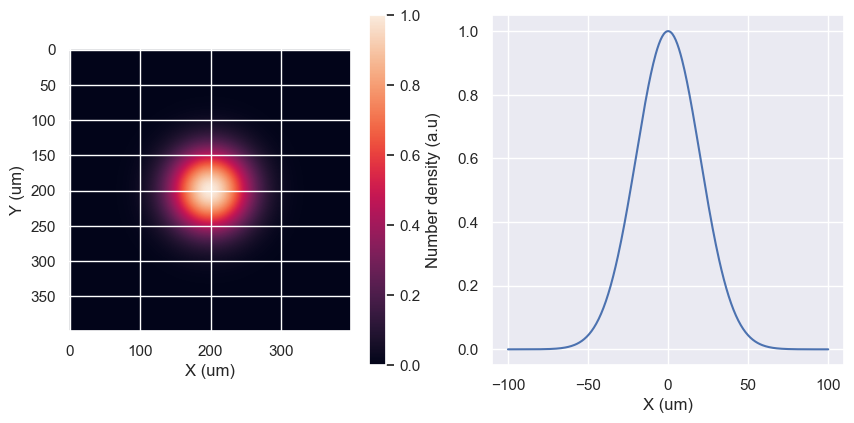

In [91]:
N_xy = 400
N_z = 20
bound = 100. * (10 ** -6) 
mu = np.array([0, 0, 0]) * (10 ** -6)
sigma = np.array([20, 20, 200]) * (10 ** -6)
cov = np.diag(sigma ** 2)
n = n3D(N_xy, bound, N_z, bound, mu, cov)
im = np.sum(n, axis=2)
im = im / np.max(im)
xData = np.mgrid[-bound:bound:im.shape[0]*1j]

plt.figure(1, figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(im)
plt.xlabel('X (um)')
plt.ylabel('Y (um)')
plt.colorbar().ax.set_ylabel('Number density (a.u)')
plt.subplot(2, 2, 2)
plt.plot(xData * (10 ** 6), im[:, np.array(N_xy / 2).astype('int')])
plt.xlabel('X (um)')
plt.show()

## <span style="color:Orange">Adding optical aberrations</span>

The main effect of measurement considered here in this project is how convolution of the atomic number density with the imaging response function, i.e. the 3D PSF, affects the resultant column-integrated image of the gas. Below is an example of how that imaging response is calculated from the Fourier transform of the objective pupil. 

For an infinitely thin object centered at the plane of best focus, the imaging response would take the form of the usual Fraunhoffer diffraction pattern, which in 2D for a circular lens we call the [Airy Disk](https://en.wikipedia.org/wiki/Airy_disk). In reality, a cold atom gas absolutely has a finite (sometimes large) thickness, and hence we need to consider slices of PSF that are out of focus and their effect on the resultant column integrated image. 

Two kinds of optical aberrations are present in this simulation that capture relevant behaviors: 1.) **defocus**-induced aberrations which arise from images taken with the object centered away from the plane of best focus for the objective lens, and 2.) primary **spherical** aberrations which results from variations in the plane of best focus for light across the radius of the lens. Defocus aberrations are easily parameterized in terms of the actual distance the object is displaced from the best focus, however spherical aberrations are left in units of phase associated with the wavefront error in the exit pupil. Don't worry about this point much, just remember that defocus is written down here in terms of a real distance and that spherical aberrations are unit-less knob we can turn up or down. Trying messing around with these two parameters below and looking at the PSF you generate.

Lastly it should be noted that are some important subtleties involving the DFT, the number of sampling points, and the distance from the pupil center that is sampled, which, if not set carefully, can add artifacts to the PSF that are not physical. I have played with these parameters a bit and included some sanity check assertions, but feel free to tweak them at your own discretion. For a discussion of this topic I refer you to Goodman's *Introduction to Fourier Optics*, chapter 5 on *Computational Diffraction and Propagation* [1].



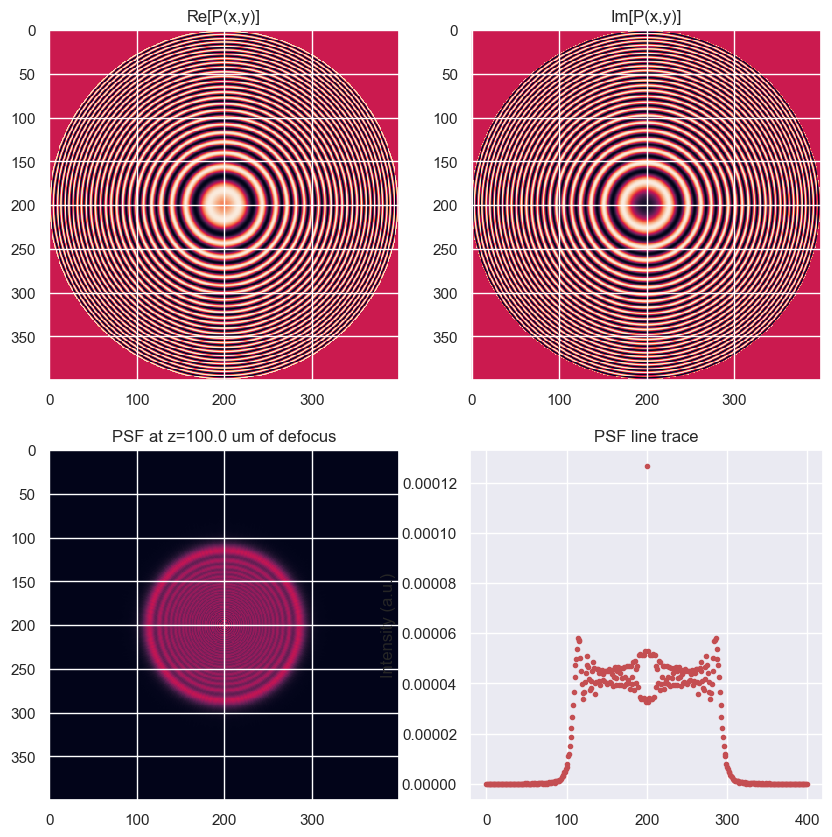

In [92]:
N = 400
bound = 1.0
mid_coord = np.array(N/2).astype('int')

lam = 0.780 * (10 ** -6)

NA = 0.4
f = 31.3 * (10 ** -3) 
D_l = 2 * f * np.tan(np.arcsin(NA))

defocus = 100.0 * (10 ** -6)
sph = 0.
_, PSF_bf = PSF2D(N, bound, lam, f, D_l, 0., sph)
pupil_function, PSF = PSF2D(N, bound, lam, f, D_l, defocus, sph)
PSF = PSF / np.max(PSF_bf)

plt.figure(1, figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(np.real(pupil_function), interpolation='none')
plt.title('Re[P(x,y)]')
plt.subplot(2, 2, 2)
plt.imshow(np.imag(pupil_function), interpolation='none')
plt.title('Im[P(x,y)]')
plt.subplot(2, 2, 3)
plt.imshow(PSF, interpolation='none')
plt.title('PSF at z=%0.1f um of defocus' % (defocus * (10 ** 6)))
plt.subplot(2, 2, 4)
plt.plot(PSF[mid_coord,:], 'r.')
plt.ylabel('Intensity (a.u.)')
plt.title('PSF line trace')
plt.show()

## <span style="color:Orange">Adding other distorting effects</span>

Putting this all together we can simulate column-integrated atomic number densities that have been imaged by a real lens! The last thing we do is downsample (or pixelize) the image to match some reasonable detector resolution and choose whether to add atom number 'noise'. 

I use the word 'noise', but what I am really describing is toy model for fluctuations in the original density distribution. If you glance at the helper functions for generating these images above, you'll see that the actual grey-scale values of the image at each simulated pixel are complete nonsense. It is a fair bit more involved to actually carry the number of atoms in the original density distribution all the way through the calculation and model the noise associated with all possible sources (detector shot noise, laser beam stability, additional optical aberrations, and real fluctuations in the density from both classical and quantum effects). Instead, whatever we get out after convolution, column integration, and downsampling, we can normalize the image to some total atom number and add some Gaussian noise that scales with that number. In effect this added noise simulates fluctuations in the perceived density that could be from any number of sources.

Note: Setting `atom_number` to 1, will not add this noise and normalize the image to unity. This is for data where the primary interest is in the shape of the distribution after imaging.

Note: The addition of the noise may introduce negative pixel values which would indicate an un-physical negative number density. Zeroing out these pixels skews the number normalization above the true atom number, so I left them in with notion that represent a real measurement variance. In experiment, very small negative $\text{OD}$ can be observed.

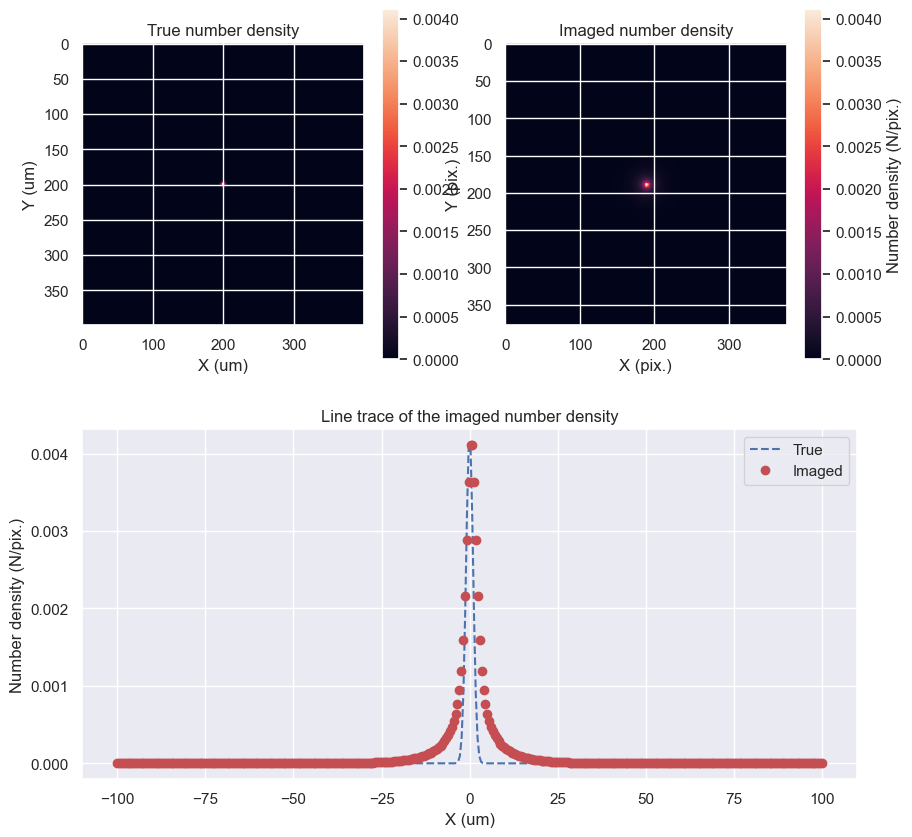

In [155]:
N_xy = 400
bound_xy = 100. * (10 ** -6) 
N_z = 81
bound_z = bound_xy
mu = np.array([0, 0, 0]) * (10 ** -6)
sigma_xy = 1.
sigma_z = 20.
sigma = np.array([sigma_xy, sigma_xy, sigma_z]) * (10 ** -6)
cov = np.diag(sigma ** 2)

lam = 0.780 * (10 ** -6)

NA = 0.4
f = 31.3 * (10 ** -3) 
D_l = 2 * f * np.tan(np.arcsin(NA))
sph = 0.

PS = 13.0 * (10 ** -6)
M = 20

atom_number = 1
gen = np.random.default_rng(seed=0)

im_true, im = ImSim(N_xy, bound_xy, N_z, bound_z, mu, cov, lam, f, D_l, sph, PS, M, atom_number, gen)

xData_true = np.mgrid[-bound_xy:bound_xy:N_xy*1j]
xData = np.mgrid[-bound_xy:bound_xy:im.shape[0]*1j]

plt.figure(1, figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(im_true, interpolation='none')
plt.colorbar()
plt.xlabel('X (um)')
plt.ylabel('Y (um)')
plt.title('True number density')
plt.subplot(2, 2, 2)
plt.imshow(im, interpolation='none')
plt.colorbar().ax.set_ylabel('Number density (N/pix.)')
plt.xlabel('X (pix.)')
plt.ylabel('Y (pix.)')
plt.title('Imaged number density')
plt.subplot(2, 1, 2)
plt.plot(xData_true * (10 ** 6), im_true[:, np.array(N_xy / 2).astype('int')], 'b--')
plt.plot(xData * (10 ** 6), im[:, np.array(im.shape[0] / 2).astype('int')], 'ro')
plt.xlabel('X (um)')
plt.ylabel('Number density (N/pix.)')
plt.title('Line trace of the imaged number density')
plt.legend(('True', 'Imaged') )
plt.show()

A useful baseline tool for analyzing these images is a simple non-linear curve fit, or least squares regression. Below is a 2D Gaussian we can employ for fitting.

In [158]:
def Gaussian2D(xy, xb, yb, xc, yc, a):
    x, y = xy
    return np.array(a * np.exp(-0.5 * ((((x - xb) / xc) ** 2) + (((y - yb) / yc) ** 2)))).ravel()

As you mess around with imaging gases of various sizes, atom number, with varying degrees of defocus and spherical aberrations, check how well the image still fits to a Gaussian distribution. 

             x0            y0   sigma_x   sigma_y         a       R^2
0 -3.430458e-21  9.642479e-21  0.000001  0.000001  0.004376  1.000000
1  5.304946e-07  5.304946e-07  0.000003  0.000003  0.002815  0.873896


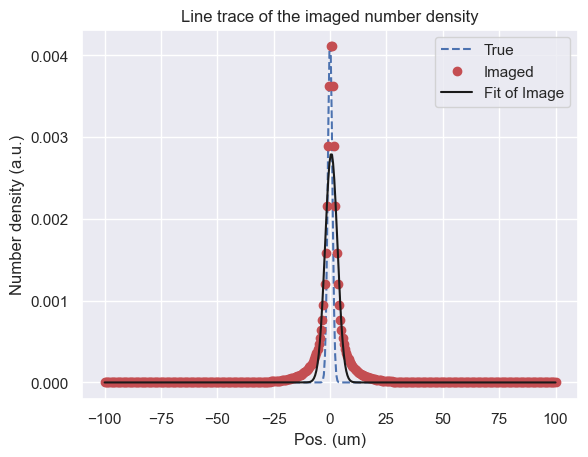

In [159]:
guess = (0., 0., sigma_xy * (10 ** -6), sigma_z * (10 ** -6), np.max(im_true))
bounds = ((-bound_xy, -bound_xy, 0, 0, 0), (bound_xy, bound_xy, np.inf, np.inf, np.inf))

xMesh_true, yMesh_true = np.meshgrid(xData_true, xData_true)
popt_true, pcov_true = sp.optimize.curve_fit(Gaussian2D, (xMesh_true.ravel(), yMesh_true.ravel()), im_true.ravel(), p0=guess, bounds=bounds)
resid_true = im_true - Gaussian2D((xMesh_true, yMesh_true), *popt_true).reshape(im_true.shape[0], im_true.shape[1])
ss_res_true = np.sum(resid_true ** 2)
ss_tot_true = np.sum(((im_true - np.mean(im_true)) ** 2))
r_squared_true = 1 - (ss_res_true / ss_tot_true)


xMesh, yMesh = np.meshgrid(xData, xData)
popt, pcov = sp.optimize.curve_fit(Gaussian2D, (xMesh.ravel(), yMesh.ravel()), im.ravel(), p0=guess, bounds=bounds)
fitted_curve = Gaussian2D((xMesh, yMesh), *popt).reshape(im.shape[0], im.shape[1])
resid = im - fitted_curve
ss_res = np.sum(resid ** 2)
ss_tot = np.sum(((im - np.mean(im)) ** 2))
r_squared = 1 - (ss_res / ss_tot)

plt.figure(1)
plt.plot(xData_true * (10 ** 6), im_true[:, np.array(N_xy / 2).astype('int')], 'b--')
plt.plot(xData * (10 ** 6), im[:, np.array(im.shape[0] / 2).astype('int') ], 'ro')
plt.plot(xData * (10 ** 6), fitted_curve[:, np.array(im.shape[0] / 2).astype('int')], 'k-')
plt.xlabel('Pos. (um)')
plt.ylabel('Number density (a.u.)')
plt.title('Line trace of the imaged number density')
plt.legend(('True', 'Imaged', 'Fit of Image') )

fit_parameters = ('x0', 'y0', 'sigma_x', 'sigma_y', 'a',  'R^2')
fit_data = np.stack((np.append(popt_true, r_squared_true), np.append(popt, r_squared)))
df = pd.DataFrame(data=fit_data, columns=fit_parameters)
print(df)

---
## <span style="color:Orange">Generating a dataset</span>

Finally, lets generate and export a few sets of images, scanning the knobs we have to play with: transverse gas size, axial gas size, atom number, focusing alignment, and spherical aberrations.

Here are the parameters we won't adjust. They have been set with certain constraints on the time to produce an image, and with a specific experimental conditions in mind. Feel free to change them.

In [160]:
N_xy = 400
bound_xy = 100. * (10 ** -6) 
N_z = 81
bound_z = bound_xy

lam = 0.780 * (10 ** -6)

# High NA
NA = 0.4
f = 31.3 * (10 ** -3) 
D_l = 2 * f * np.tan(np.arcsin(NA))
PS = 13.0 * (10 ** -6)
M = 20

# Low NA
# NA = 0.2
# f = 31.3 * (10 ** -3) 
# D_l = 2 * f * np.tan(np.arcsin(NA))
# PS = 13.0 * (10 ** -6)
# M = 4

Now we set the parameters we want to vary and export the image. With the above fixed set of parameters (namely the number of samples) each image should only take ~ 10 seconds to generate and export to file.

In [166]:
mu_x = 0.0
mu_y = 0.0
mu_z = 0.0
sigma_x = 2.5
sigma_y = 2.5
sigma_z = 2.5 
atom_number = 1
Z04 = 0.0

mu = np.array([mu_x, mu_y, mu_z]) * (10 ** -6)
sigma = np.array([sigma_x, sigma_y, sigma_z]) * (10 ** -6)
cov = np.diag(sigma ** 2)

for i in np.arange(1):
    seed = i
    gen = np.random.RandomState(seed=seed)
    
    _, im = ImSim(N_xy, bound_xy, N_z, bound_z, mu, cov, lam, f, D_l, sph, PS, M, atom_number, gen)
    
    dataset_name = 'Heavy_tails\\'
    file_name = 'HiNA.' + 'atom_num=%i.mu=(%0.1f...%0.1f...%0.1f).sigma=(%0.1f...%0.1f...%0.1f).Z04=%0.1f.seed=%i.tiff' % (atom_number, mu_x, mu_x, mu_z, sigma_x, sigma_y, sigma_z, Z04, seed)
    
    ski.io.imsave(fname=dataset_name + file_name, arr=im)

C:\Users\Max\AppData\Local\Temp\ipykernel_36848\3553066740.py:23: UserWarning: Heavy_tails\HiNA.atom_num=1.mu=(0.0...0.0...0.0).sigma=(2.5...2.5...2.5).Z04=0.0.seed=0.tiff is a low contrast image
  ski.io.imsave(fname=dataset_name + file_name, arr=im)


## <span style="color:Orange">References</span>

* [__<span style="color:Red">1</span>__] Goodman, J. W. (2005). Introduction to Fourier optics. Introduction to Fourier optics, 3rd ed.

* [__<span style="color:Red">2</span>__] Foot, C. (2005). Atomic physics. Oxford University Press, USA.

---

## <span style="color:Orange">Acknowledgements</span>

* Initial version: Max Gold with some guidence from Mark Neubauer

© Copyright 2023